<a href="https://colab.research.google.com/github/PedroAdair/TesisMaestria/blob/main/Anonimizacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title gower (0.1.2)
!pip install gower 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#@title networkx
!pip install networkx 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#@title Igraph (1.6.7)
!pip install igraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 34.8 MB/s eta 0:00:00


In [4]:
import gower
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import igraph as ig
import networkx as nx

#1. Construcción del grafo

La primer tarea consiste en construir un grafo a partir de la base de datos que se tiene previemente, como nuestros registros contienen observaciones numericas y categoricas, se opta por usar el coeficiente de similitud de Gower.

In [5]:
#link donde se encuentra la base de datos
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

# leer el archivo CSV de la base de datos adult
df = pd.read_csv(url, header=None)

In [6]:
#Para estos primeros resultados, solo trabajare con n=100
n = 100
df  = df.head(n)

In [11]:
matriz_distancias = gower.gower_matrix(df)
matriz_distancias

array([[0.        , 0.31261942, 0.31625032, ..., 0.45070857, 0.503844  ,
        0.39384323],
       [0.31261942, 0.        , 0.4071618 , ..., 0.34162003, 0.44175005,
        0.4847547 ],
       [0.31625032, 0.4071618 , 0.        , ..., 0.34806943, 0.36541176,
        0.3442596 ],
       ...,
       [0.45070857, 0.34162003, 0.34806943, ..., 0.        , 0.49986997,
        0.49014324],
       [0.503844  , 0.44175005, 0.36541176, ..., 0.49986997, 0.        ,
        0.576338  ],
       [0.39384323, 0.4847547 , 0.3442596 , ..., 0.49014324, 0.576338  ,
        0.        ]], dtype=float32)

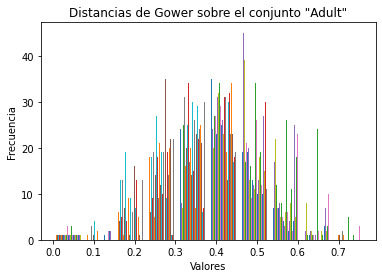

In [12]:
plt.hist(matriz_distancias)
plt.title('Distancias de Gower sobre el conjunto "Adult"')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.show()

Surge aqui un nuevo reto: ¿a partir de que umbral definimos que 2 registros (vértices) tienen una arista en común? 

Para dar respuesta a esta pregunta nos basamos en el concepto de **eficiencia global**

In [53]:
# Crear un grafo completo con las distancias de la matriz
G = nx.complete_graph(matriz_distancias.shape[0], create_using=nx.Graph())
for i, j in G.edges():
    G[i][j]['weight'] = matriz_distancias[i][j]

In [54]:
# Calcular la eficiencia global del grafo completo
E = nx.global_efficiency(G)
E

1.0

In [55]:
threshold=0.40

In [56]:
# Eliminar las aristas del grafo completo en orden ascendente de sus valores de distancia
while E > threshold:
    sorted_edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'])
    G.remove_edge(*sorted_edges[0][:2])
    E = nx.global_efficiency(G)

# Crear la matriz de adyacencia a partir de las aristas restantes
adj_matrix = np.zeros_like(matriz_distancias)
for i, j in G.edges():
    adj_matrix[i][j] = 1
    adj_matrix[j][i] = 1

In [57]:
# Calcular la eficiencia global del grafo adaptado
E = nx.global_efficiency(G)
E

0.3947979797979963

procedemos a construir el grafo

In [58]:
# Crear el grafo a partir de la matriz de adyacencia
G = ig.Graph.Adjacency((adj_matrix > 0).tolist())

# Definir el layout del grafo
layout = G.layout("kk")
# Obtener las posiciones de los nodos
pos = np.asarray([layout[k] for k in range(len(G.vs))])

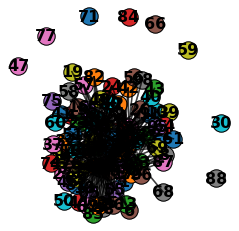

In [59]:
# Plotear el grafo utilizando matplotlib.pyplot
plt.figure(figsize=(4,4))
plt.scatter(pos[:, 0], pos[:, 1], color="gray", alpha=0.5, s=300)
for i in range(len(G.es)):
    edge = G.es[i]
    start = pos[edge.tuple[0]]
    end = pos[edge.tuple[1]]
    plt.plot([start[0], end[0]], [start[1], end[1]], color="black", alpha=0.5)
for i in range(len(G.vs)):
    node = G.vs[i]
    plt.scatter(pos[i, 0], pos[i, 1], edgecolor="black", linewidth=1, s=300)
    plt.text(pos[i, 0], pos[i, 1], str(i+1), horizontalalignment="center", verticalalignment="center", fontsize=16, fontweight="bold")
plt.axis("off")
plt.show()

##1.2 Construcción

#2. Detección de comunidades

In [61]:
import igraph as ig
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter


In [62]:
# Aplicar el método de detección de comunidades Infomap
communities = G.community_infomap()

# Obtener el número de comunidades
num_communities = len(communities)

# Imprimir el número de comunidades y los nodos de cada comunidad
print(f"El grafo tiene {num_communities} comunidades:")
for i in range(num_communities):
    nodes = communities[i]
    print(f"Comunidad {i+1}: {nodes}")

El grafo tiene 11 comunidades:
Comunidad 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 63, 64, 66, 67, 68, 69, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 84, 85, 86, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99]
Comunidad 2: [29]
Comunidad 3: [46]
Comunidad 4: [58]
Comunidad 5: [62]
Comunidad 6: [65]
Comunidad 7: [70]
Comunidad 8: [76]
Comunidad 9: [83]
Comunidad 10: [87]
Comunidad 11: [90]


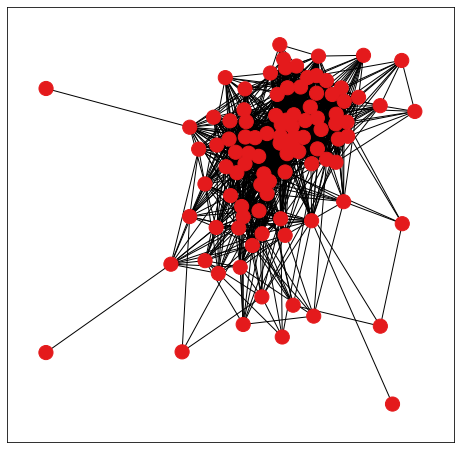

In [92]:
# Aplicar el algoritmo Infomap para detectar las comunidades
im = ig_g.community_infomap()

# Dibujar el grafo coloreando cada comunidad de un color distinto
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, node_size=200, cmap=plt.cm.Set1, node_color=im.membership)
nx.draw_networkx_edges(g, pos)
plt.show()

In [93]:
comunidades = im.sizes()
print(comunidades)

[100]


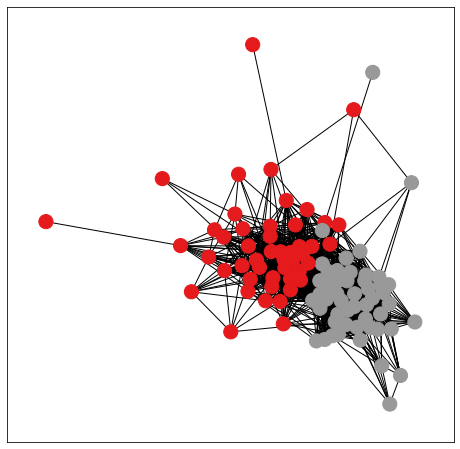

In [94]:
lp = ig_g.community_label_propagation() # lp
# Dibujar el grafo coloreando cada comunidad de un color distinto
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=200, cmap=plt.cm.Set1, node_color=lp.membership)
nx.draw_networkx_edges(G, pos)
plt.show()

In [95]:
comunidades = lp.sizes()
print(comunidades)

[48, 52]
